In [30]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import decimal
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from util.db_util import DatabaseUtility

In [31]:
# Read .bashrc and update os.environ
bashrc_path = os.path.expanduser("~/.bashrc")
if os.path.exists(bashrc_path):
    with open(bashrc_path, "r") as f:
        for line in f:
            if line.startswith("export "):
                key_value = line.replace("export ", "").strip().split("=", 1)
                if len(key_value) == 2:
                    key, value = key_value
                    os.environ[key] = value.strip().strip("'").strip('"')

db_util = DatabaseUtility()

# Fetch training data
test_year = 2025
db_util.cursor.execute(f"""
    SELECT player_id, name, draft_cap, cupps_score, production_score, size_score, avg_fppg_nfl 
    FROM te_model_data
    WHERE draft_year NOT IN ({test_year}, 2025)
""")
rows = db_util.cursor.fetchall()
columns = [desc[0] for desc in db_util.cursor.description]
df_train = pd.DataFrame(rows, columns=columns)

# Fetch test data (test year WR prospects)
db_util.cursor.execute(f"""
    SELECT player_id, name, draft_cap, cupps_score, production_score, size_score, avg_fppg_nfl 
    FROM te_model_data
    WHERE draft_year = {test_year};
""")

rows_2025 = db_util.cursor.fetchall()
df_test = pd.DataFrame(rows_2025, columns=columns)
db_util.conn.close()

# Store identifiers for later merging
df_test_identifiers = df_test[["player_id", "name"]].copy()

In [32]:
null_columns = df_train.columns[df_train.isnull().any()]

print("\nSummary of columns with nulls:")
for col in null_columns:
    null_count = df_train[col].isnull().sum()
    avg_value = df_train[col].mean()
    print(f"{col}: {null_count} missing | Avg (ignoring nulls): {avg_value:.2f}")

# Convert numeric columns to float, including any decimal.Decimal values
for df in [df_train, df_test]:
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (int, float, np.number, decimal.Decimal))).any():
            df[col] = df[col].astype(float)

df_train_numeric_cols = df_train.select_dtypes(include=[np.number]).columns
df_test_numeric_cols = df_test.select_dtypes(include=[np.number]).columns
# Any player that did not ever hit 10 games in a season will have a NULL value for average NFL FPPG.
# I am deciding to assign them a value of 0 to indicate the level of which they busted, rather than the average of the rest of our dataset.
df_train["avg_fppg_nfl"] = df_train["avg_fppg_nfl"].fillna(0)
df_train[df_train_numeric_cols] = df_train[df_train_numeric_cols].fillna(df_train[df_train_numeric_cols].mean())
df_test[df_test_numeric_cols] = df_test[df_test_numeric_cols].fillna(df_test[df_test_numeric_cols].mean())


Summary of columns with nulls:


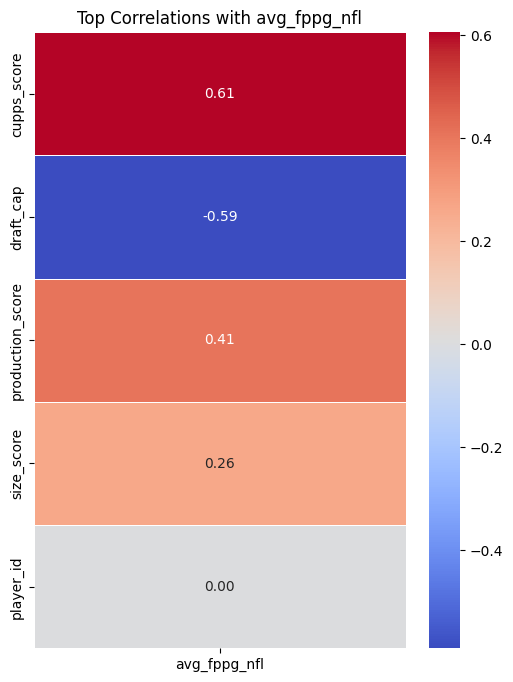

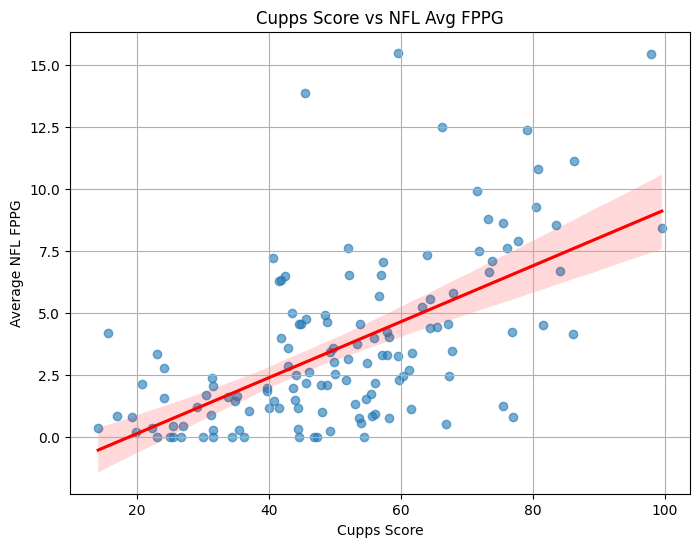

In [33]:
# Compute correlation matrix
correlation_matrix = df_train[df_train_numeric_cols].corr()

# Get correlations with avg_fppg_nfl and sort them (using abs since DC is inversely correlated)
correlations = correlation_matrix["avg_fppg_nfl"].dropna().abs().sort_values(ascending=False)

# Select the top N correlated features (excluding avg_fppg_nfl itself)
top_corr_features = correlations.index[1:50]  # Get top 10 correlated features

# Extract the correlation matrix for the selected features
top_corr_matrix = correlation_matrix.loc[top_corr_features, ["avg_fppg_nfl"]]

# Plot the heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top Correlations with avg_fppg_nfl")
plt.show()

# --- Scatter plot of cupps_score vs avg_fppg_nfl ---
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_train,
    x="cupps_score",
    y="avg_fppg_nfl",
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
    )
plt.title("Cupps Score vs NFL Avg FPPG")
plt.xlabel("Cupps Score")
plt.ylabel("Average NFL FPPG")
plt.grid(True)
plt.show()


📈 Sorted WR Predictions (2025 Prospects):
 player_id              name   CUPPS  Predicted FPPG  Actual FPPG   Residual
     18112  Colston Loveland 96.3554       15.609345          0.0 -15.609345
     17166      Tyler Warren 90.5243       15.262639          0.0 -15.262639
     18140      Mason Taylor 73.2116        5.912099          0.0  -5.912099
     18382 Harold Fannin Jr. 76.9556        5.451757          0.0  -5.451757
     17178 Terrance Ferguson 70.6035        4.701752          0.0  -4.701752
     17366     Elijah Arroyo 62.1818        3.873483          0.0  -3.873483
     17088 Oronde Gadsden II 61.3500        3.207288          0.0  -3.207288
     17857       Gunnar Helm 48.6982        2.130643          0.0  -2.130643
     17222    Mitchell Evans 49.7411        1.870548          0.0  -1.870548
     19878     Jackson Hawes 32.2005        0.084462          0.0  -0.084462
     17671      Robbie Ouzts 29.6331        0.084447          0.0  -0.084447
     17177    Moliki Matavao 31.1

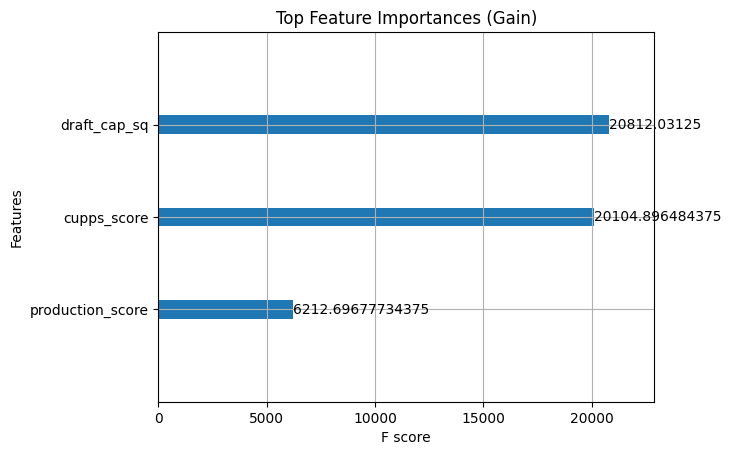

In [34]:
# Define input/output
y_train = df_train["avg_fppg_nfl"]
y_test_actual = df_test["avg_fppg_nfl"]

X_train = df_train.copy()
X_test = df_test.copy()

#Add a nonlinear version of draft capital
X_train["draft_cap_sq"] = 1 / (X_train["draft_cap"].fillna(300) + 1)
X_test["draft_cap_sq"] = 1 / (X_test["draft_cap"].fillna(300) + 1)

#Exponentially weight samples with higher CUPPS scores
sample_weights = np.exp(X_train["cupps_score"] / 10)
#Only include three features in the model training to avoid noise
final_features = ["cupps_score", "production_score", "draft_cap_sq"]
#Monotone constraints allows us to tell our model that we believe these three features should generally be positively correlated with the prediction values
monotone_constraints = "(1,1,1)"

xgb_simple = xgb.XGBRegressor(
    max_depth=6, n_estimators=300, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.7,
    objective="reg:squarederror",
    monotone_constraints = monotone_constraints,    
    random_state=42
)

#Remove the features we don't want to feed the model, only feed it our final features
X_train = X_train[final_features]
X_test = X_test[final_features]
xgb_simple.fit(X_train, y_train, sample_weight=sample_weights)

#Predict on test set
y_pred = xgb_simple.predict(X_test)

#This function allows us to exponentially boost the FPPG predictions of elite prospects
#Max boost = 5 extra FPPG
#Center = 80 - the CUPPS score at which the boost hits 50%
#CUPPS 80: boost ≈ 2.5 FPPG
#CUPPS <80: less than 2.5
#CUPPS >80: more than 2.5, approaching 5 as it nears 95+
def stretch_elite_predictions(preds, cupps):
    max_boost = 5
    steepness = 0.25
    center = 80
    boost = max_boost / (1 + np.exp(-steepness * (cupps - center)))
    return preds + boost

y_pred = stretch_elite_predictions(y_pred, X_test["cupps_score"])

# Create residuals DataFrame
df_results = pd.DataFrame({
    "Actual FPPG": y_test_actual.values,
    "Predicted FPPG": y_pred,
    "Residual (Actual - Predicted)": y_test_actual.values - y_pred
})

# Merge predictions, actuals, and residuals
df_predictions = df_test_identifiers.copy()
df_predictions["CUPPS"] = X_test["cupps_score"]
df_predictions["Predicted FPPG"] = y_pred
df_predictions["Actual FPPG"] = y_test_actual.values
df_predictions["Residual"] = df_predictions["Actual FPPG"] - df_predictions["Predicted FPPG"]

# Sort by predicted FPPG
df_predictions = df_predictions.sort_values(by="Predicted FPPG", ascending=False).reset_index(drop=True)

# Display
print(f"\n📈 Sorted WR Predictions ({test_year} Prospects):")
print(df_predictions.to_string(index=False))

xgb.plot_importance(xgb_simple, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances (Gain)")
plt.show()

| Metric                   | Correlation Matrix (`.corr()`)            | XGBoost Gain Importance                                 |
| ------------------------ | ----------------------------------------- | ------------------------------------------------------- |
| **Type of Relationship** | Linear only                               | Captures nonlinear, hierarchical splits                 |
| **Context**              | Global — compares entire column to target | Local — evaluates each tree's split decision            |
| **Interaction Effects**  | Not captured                              | Captures feature interactions via tree structure        |
| **Output Value**         | Ranges -1 to 1                            | Arbitrary (based on cumulative gain across tree splits) |
| **Sensitivity**          | Sensitive to outliers and collinearity    | Sensitive to how features guide splits and improve fit  |
| **Interpretability**     | More intuitive but simplistic             | More nuanced, but harder to intuit directly             |
